In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf #derin √∂ƒürenme k√ºt√ºphanesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator #g√∂rselleri y√ºklemek
from tensorflow.keras.models import Sequential#katmanlarƒ± √ºst√ºste sƒ±ralƒ± olark kullanmak
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#Conv2D->g√∂r√ºnt√ºden √∂zellik √ßƒ±karƒ±r
#MaxPooling2D ‚Üí boyutu k√º√ß√ºlt√ºr, √∂nemli √∂zellikleri alƒ±r.
#Flatten ‚Üí 2D‚Äôden 1D‚Äôye d√∂n√º≈üt√ºr√ºr (klasik yapay sinir aƒüƒ±na baƒülamak i√ßin).
#Dense ‚Üí asƒ±l kararlarƒ±n verildiƒüi yer
#Dropout ‚Üí overfitting‚Äôi engellemek i√ßin bazƒ± n√∂ronlarƒ± rastgele kapatƒ±r.
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


2025-09-23 17:07:18.506368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758647238.849621      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758647238.942750      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (150, 150)
batch_size = 32


In [3]:
train_datagen=ImageDataGenerator(rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            validation_split=0.2)


### Veri √ñni≈üleme

Bu a≈üamada modelimin daha iyi genelleme yapabilmesi i√ßin **ImageDataGenerator** kullandƒ±m:

- **Rescale:** Piksel deƒüerlerini normalize ettim. Model bu sayede daha hƒ±zlƒ± ve stabil √∂ƒüreniyor.  
- **Rotation:** G√∂rselleri 15 derece d√∂nd√ºrd√ºm. Her MR aynƒ± a√ßƒ±dan √ßekilmeyeceƒüi i√ßin model farklƒ± a√ßƒ±lara dayanƒ±klƒ± hale geliyor.  
- **Width/Height Shift:** G√∂rselleri kaydƒ±rarak t√ºm√∂r√ºn farklƒ± pozisyonlarda olmasƒ±na kar≈üƒ± dayanƒ±klƒ± hale getirdim.  
- **Shear:** Hafif perspektif kaymalarƒ± ekledim.
 * * √ñrneƒüin hastanƒ±n ba≈üƒ± hafif eƒüilmi≈ü olabilir ‚Üí model sadece dik g√∂r√ºnt√ºlere alƒ±≈üƒ±rsa hata yapar.
- **Zoom:** Yakƒ±nla≈ütƒ±rma/uzakla≈ütƒ±rma ile √ße≈üitlilik kazandƒ±rdƒ±m.  
- **Horizontal Flip:** G√∂rseli yatay √ßevirerek, t√ºm√∂r saƒüda ya da solda olsa da √∂ƒürenmesini saƒüladƒ±m.  
- **Validation Split:** Verinin %20‚Äôsini validation i√ßin ayƒ±rdƒ±m. B√∂ylece modelin ezberleyip ezberlemediƒüini kontrol edebileceƒüim.


In [4]:
train_generator=train_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 4571 images belonging to 4 classes.


**DATASETƒ∞ ANLAMAK**

Dataset i√ßerisinde 4 klas√∂r var. Her klas√∂r aslƒ±nda bir etiketi temsil ediyor.
1. Glioma
 
* Beyinde g√∂r√ºlen t√ºm√∂r tipi
* MRI g√∂r√ºnt√ºs√ºnde farklƒ± b√∂lgelerde √ßƒ±kabilir.
* Model "g√∂rd√ºƒü√ºm resim glioma mƒ±" diye √∂ƒürenecek 
 
2. Meningioma

*  Beyin zarƒ±ndan kaynaklanan t√ºm√∂r.
*   G√∂r√ºnt√ºs√º glioma‚Äôdan farklƒ±dƒ±r.
*   Ayrƒ± bir sƒ±nƒ±f olarak √∂ƒüretiliyor. 

3. Pituitary
 
* Hipofiz bezi t√ºm√∂r√º (beynin altƒ±nda k√º√ß√ºk bir b√∂lgede). 
* MRI‚Äôda genellikle beynin ortasƒ±na yakƒ±n bir b√∂lgede g√∂r√ºn√ºr.

4.  No Tumor
   * Beyinde hi√ß t√ºm√∂r yok ‚Üí saƒülƒ±klƒ± MRI g√∂r√ºnt√ºs√º.

* Model bu durumda ‚Äút√ºm√∂r yok‚Äù kararƒ±nƒ± verecek.

Bilgisayar yazƒ±yla deƒüil sayƒ±yla √ßalƒ±≈üƒ±r bu y√ºzden **flow_from_directory** bu i≈ülemi ger√ßekle≈ütirir.
* glioma ‚Üí 0
* meningioma ‚Üí 1
* pituitary ‚Üí 2
* no_tumor ‚Üí 3

In [5]:
print("Sƒ±nƒ±f ƒ∞ndeksleri\n:",train_generator.class_indices)



Sƒ±nƒ±f ƒ∞ndeksleri
: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
val_generator = train_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1141 images belonging to 4 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-mri-dataset/Testing",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


### Veri Setinin Ayrƒ±lmasƒ±

- **Training Set (%80):** Modelin √∂ƒürenmesi i√ßin kullanƒ±lan veriler.  
- **Validation Set (%20):** Eƒüitim sƒ±rasƒ±nda modelin ezberleyip ezberlemediƒüini kontrol etmek i√ßin kullanƒ±lan veriler.  
- **Test Set:** Eƒüitim tamamlandƒ±ktan sonra modelin daha √∂nce hi√ß g√∂rmediƒüi verilerle ger√ßek performansƒ±nƒ± √∂l√ßmek i√ßin ayrƒ±lmƒ±≈ütƒ±r.  

`ImageDataGenerator` i√ßindeki `validation_split=0.2` parametresi sayesinde, Training klas√∂r√ºndeki veriler otomatik olarak %80 eƒüitim, %20 doƒürulama olacak ≈üekilde ayrƒ±ldƒ±.  
Ayrƒ±ca Kaggle datasetinde zaten ayrƒ± bir **Testing** klas√∂r√º bulunduƒüu i√ßin, final deƒüerlendirmeyi bu veriler √ºzerinde yapacaƒüƒ±z.


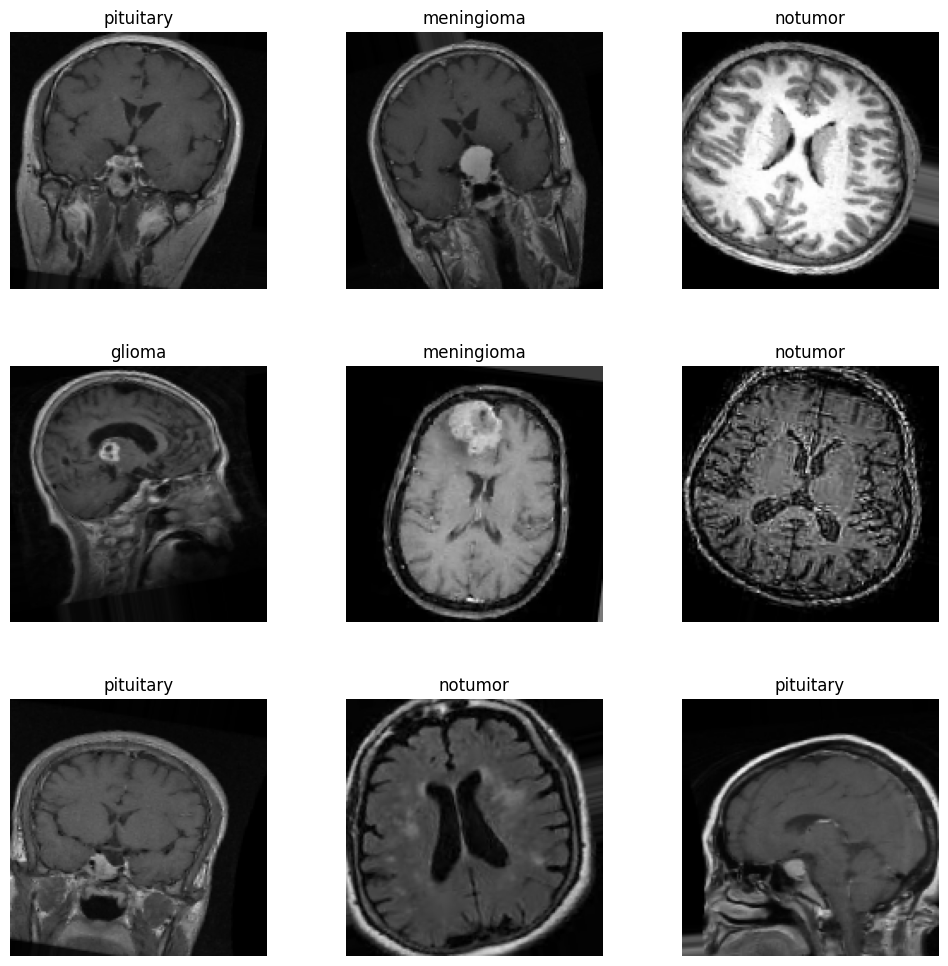

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i].astype("float32")) 
    plt.axis("off")
    
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  
plt.show()


üìä**Eƒüitim Verisinden √ñrnek G√∂rseller**


Bu g√∂rselle≈ütirmede eƒüitim veri setinden rastgele se√ßilen 9 MRI g√∂r√ºnt√ºs√º yer almaktadƒ±r.

G√∂rseller **ImageDataGenerator** aracƒ±lƒ±ƒüƒ±yla y√ºklendi ve 3x3 grid ≈üeklinde g√∂sterildi.

Her resmin √ºst kƒ±smƒ±nda, **flow_from_directory** tarafƒ±ndan otomatik atanan sƒ±nƒ±f etiketi yazmaktadƒ±r.

Etiketler, **one-hot encoding** formatƒ±ndan geri d√∂n√º≈üt√ºr√ºlerek okunabilir hale getirildi.

Bu g√∂rselle≈ütirme sayesinde:

* G√∂rsellerin doƒüru y√ºklendiƒüini,
* Etiketlerin klas√∂r isimlerine g√∂re doƒüru ≈üekilde e≈ülendiƒüini,
* Her sƒ±nƒ±ftan (glioma, meningioma, pituitary, notumor) √∂rneklerin veri setinde bulunduƒüunukontrol etmi≈ü olduk.
* Bu a≈üama, veri √∂n i≈üleme s√ºrecinin doƒürulama adƒ±mƒ±dƒ±r. Modeli eƒüitmeden √∂nce verilerin doƒüru geldiƒüinden emin olmamƒ±zƒ± saƒülar.



In [9]:
import os

train_path = "../input/brain-tumor-mri-dataset/Training"

class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print(class_counts)


{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}


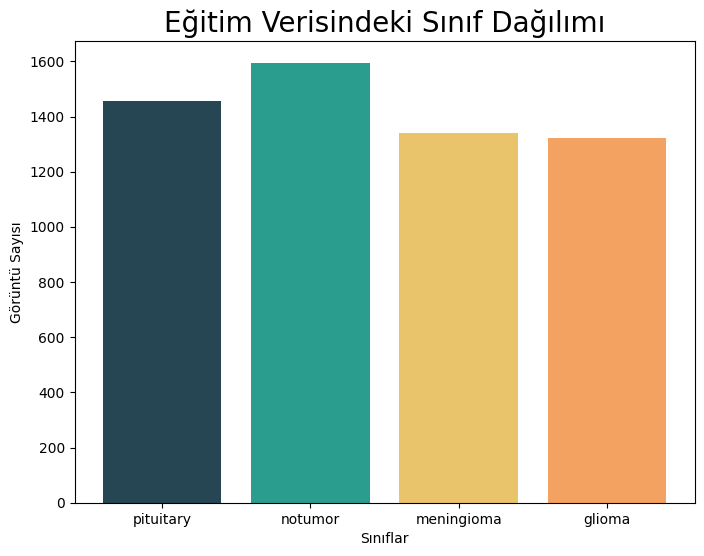

In [10]:
plt.figure(figsize=(8,6))
plt.bar(class_counts.keys(),class_counts.values(),color= [
    "#264653",  
    "#2A9D8F",  
    "#E9C46A",
    "#F4A261"   
])

plt.title("Eƒüitim Verisindeki Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±",fontsize=20)
plt.xlabel("Sƒ±nƒ±flar")
plt.ylabel("G√∂r√ºnt√º Sayƒ±sƒ±")
plt.show()

**üìä Eƒüitim Verisi Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±**

Yukarƒ±daki √ßubuk grafikte, eƒüitim veri setindeki her sƒ±nƒ±fa ait g√∂r√ºnt√º sayƒ±sƒ± g√∂sterilmektedir:


* Pituitary: ~1450 g√∂r√ºnt√º
* No Tumor: ~1600 g√∂r√ºnt√º
* Meningioma: ~1350 g√∂r√ºnt√º
* Glioma: ~1320 g√∂r√ºnt√º


Veri setindeki sƒ±nƒ±flar arasƒ±nda b√ºy√ºk bir dengesizlik yok, sayƒ±lar birbirine olduk√ßa yakƒ±n.

Bu durum modelin eƒüitiminde avantajlƒ±dƒ±r √ß√ºnk√º model bir sƒ±nƒ±fa fazla, diƒüerine az √∂rnek g√∂rerek yanlƒ± √∂ƒürenmeye daha az meyilli olur.

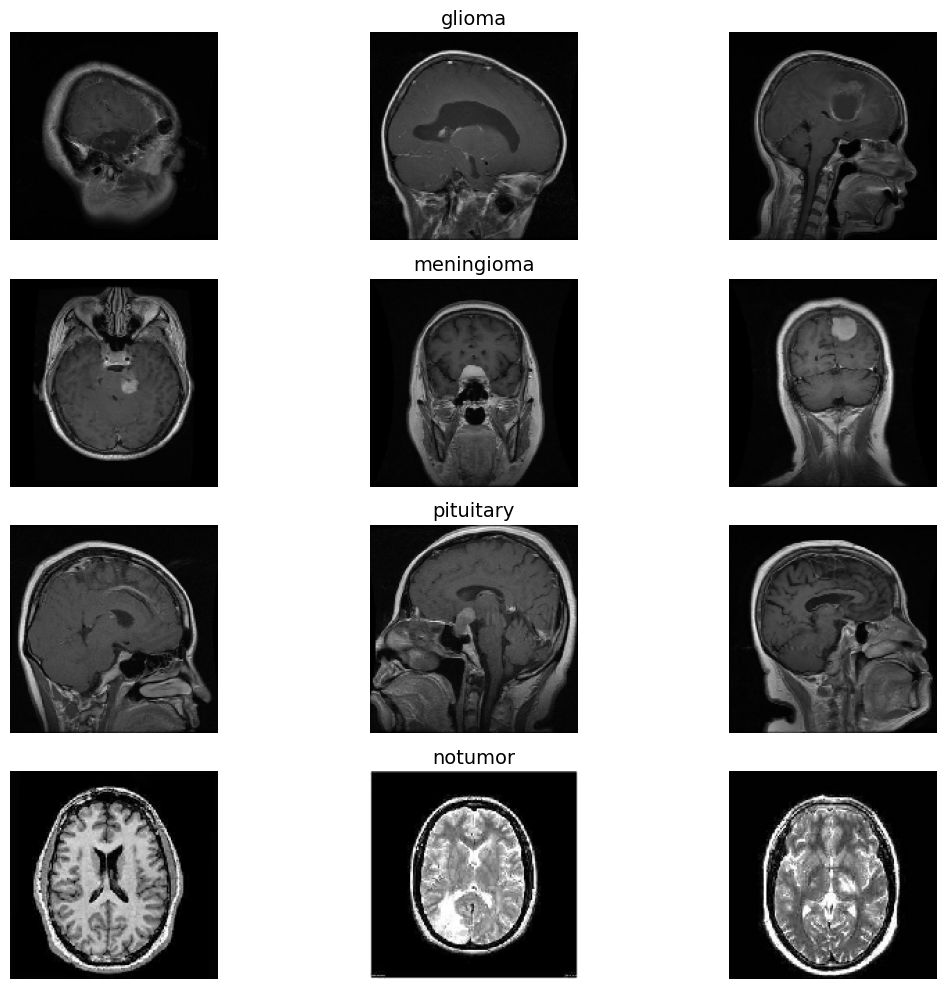

In [11]:
import os
import random
from tensorflow.keras.preprocessing import image

classes = ["glioma", "meningioma", "pituitary", "notumor"]

plt.figure(figsize=(12, 10))

for row, class_name in enumerate(classes):
    class_dir = os.path.join(train_path, class_name)
    images = os.listdir(class_dir)
    
   
    sample_images = random.sample(images, 3)
    
    for col, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size=(150, 150))
        
        plt.subplot(len(classes), 3, row*3 + col + 1)
        plt.imshow(img)
        plt.axis("off")
        
        if col == 1:
            plt.title(class_name, fontsize=14)

plt.tight_layout()
plt.show()


## MRI G√∂rsellerinin Sƒ±nƒ±flara G√∂re ƒ∞ncelenmesi  

Her sƒ±nƒ±ftan √∂rnek MRI g√∂r√ºnt√ºleri incelendi. Burada ama√ß medikal te≈ühis yapmak deƒüil, veri setindeki g√∂rsel farklƒ±lƒ±klarƒ± yazƒ±lƒ±m a√ßƒ±sƒ±ndan g√∂zlemlemek ve modelin neyi √∂ƒürenmesi gerektiƒüini netle≈ütirmektir.  

### 1. Glioma  
- G√∂rsellerde beyin dokusu i√ßinde yoƒüunluk farklƒ±lƒ±klarƒ± ve d√ºzensiz ≈üekiller g√∂ze √ßarpƒ±yor.  
- Bu sƒ±nƒ±f, model i√ßin zorlayƒ±cƒ± olabilir √ß√ºnk√º sƒ±nƒ±rlar keskin deƒüil; farklƒ± b√∂lgelerde farklƒ± ≈üekilde √ßƒ±kabiliyor.  

### 2. Meningioma  
- Daha d√ºzenli, kenara yakƒ±n ve net konturlara sahip yapƒ±lar g√∂ze √ßarpƒ±yor.  
- G√∂rseller model i√ßin daha ‚Äúayƒ±rt edilebilir‚Äù g√∂r√ºn√ºyor, bu y√ºzden √∂ƒürenmesi g√∂rece kolay olabilir.  

### 3. Pituitary  
- G√∂rsellerde beynin alt kƒ±smƒ±na yakƒ±n k√º√ß√ºk ve yoƒüun alanlar dikkat √ßekiyor.  
- Konum bilgisi burada kritik, √ß√ºnk√º diƒüer t√ºm√∂r tiplerinden farklƒ± bir b√∂lgede tekrarlanƒ±yor. Bu da modele g√º√ßl√º bir sinyal saƒülar.  

### 4. No Tumor  
- Beyin dokusu homojen g√∂r√ºn√ºyor, anormal parlaklƒ±k veya kitle yok.  
- Bu sƒ±nƒ±fƒ±n doƒüru √∂ƒürenilmesi √∂nemli, √ß√ºnk√º aksi durumda model yanlƒ±≈ü alarm √ºretebilir (false positive).  

---

### √áƒ±karƒ±mlar  
- Veri setindeki sƒ±nƒ±flar g√∂rsel a√ßƒ±dan ger√ßekten farklƒ± ve bu farklar makine √∂ƒürenmesi a√ßƒ±sƒ±ndan anlamlƒ± √∂zellikler ta≈üƒ±yor.  
- **Glioma** sƒ±nƒ±fƒ± en zor olan gibi g√∂r√ºn√ºyor, √ß√ºnk√º farklƒ± pozisyonlarda ve ≈üekillerde √ßƒ±kabiliyor.  
- **Meningioma** ve **Pituitary** daha konum odaklƒ± ve d√ºzenli sƒ±nƒ±flar, modelin daha hƒ±zlƒ± √∂ƒürenmesini saƒülayabilir.  
- **No Tumor** sƒ±nƒ±fƒ± kritik √ß√ºnk√º yanlƒ±≈ü sƒ±nƒ±flandƒ±rma modelin g√ºvenilirliƒüini ciddi ≈üekilde d√º≈ü√ºr√ºr.  


In [12]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

sample_img_path = os.path.join(train_path, "glioma", random.choice(os.listdir(os.path.join(train_path, "glioma"))))

img = load_img(sample_img_path, target_size=(150, 150))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

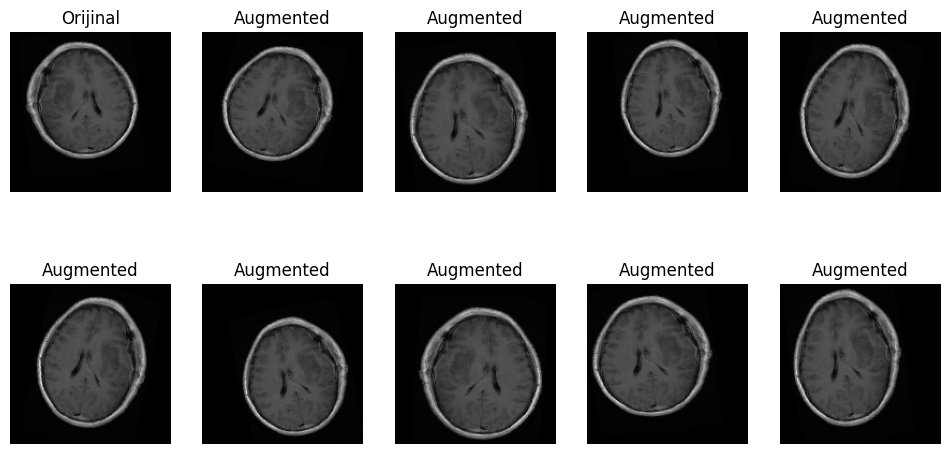

In [13]:
i = 1
plt.figure(figsize=(12, 6))

for batch in train_datagen.flow(img_array, batch_size=1):
    plt.subplot(2, 5, i)
    plt.imshow(batch[0])
    if i == 1:
        plt.title("Orijinal")
    else:
        plt.title("Augmented")
    plt.axis("off")
    i += 1
    if i > 10:
        break

plt.show()


### Veri √áoƒüaltma √ñrneƒüi


A≈üaƒüƒ±daki g√∂rselde tek bir MRI g√∂r√ºnt√ºs√ºn√ºn, **ImageDataGenerator** ile √ºretilmi≈ü farklƒ± versiyonlarƒ± g√∂sterilmektedir.  
- ƒ∞lk kutucuk **orijinal resmi**, diƒüerleri ise **d√∂nd√ºrme, kaydƒ±rma, yakƒ±nla≈ütƒ±rma ve yatay √ßevirme** gibi d√∂n√º≈ü√ºmler uygulanmƒ±≈ü halini temsil etmektedir.  
- Bu sayede model yalnƒ±zca birebir aynƒ± resmi deƒüil, farklƒ± a√ßƒ±lardan ve konumlardan gelen varyasyonlarƒ±nƒ± da √∂ƒürenmektedir.  
- B√∂ylelikle **overfitting riski azalƒ±r** ve model, ger√ßek hayatta kar≈üƒ±la≈üacaƒüƒ± √ße≈üitli MRI g√∂r√ºnt√ºlerine kar≈üƒ± daha dayanƒ±klƒ± hale gelir.  

> Tek bir g√∂r√ºnt√ºden onlarca farklƒ± eƒüitim √∂rneƒüi elde ederek, sƒ±nƒ±rlƒ± veri setinde bile g√º√ßl√º bir model geli≈ütirmek m√ºmk√ºn olur.


In [14]:
import warnings
warnings.filterwarnings("ignore")

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
#ilk katman
model.add(MaxPooling2D(pool_size=(2,2)))
#(3,3) Conv2D‚Äôde filtre boyutu, MaxPooling‚Äôde k√º√ß√ºltme boyutu.


I0000 00:00:1758647259.586407      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758647259.587112      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


32 tane 3x3 filtre ‚Üí basit kenar, √ßizgi gibi detaylarƒ± √∂ƒüreniyor.

ReLU ‚Üí negatifleri sƒ±fƒ±rlar, model daha iyi √∂ƒürenir.

MaxPooling ‚Üí g√∂r√ºnt√ºy√º k√º√ß√ºlt√ºr, ama √∂nemli kƒ±sƒ±mlarƒ± korur.

In [15]:
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


Bu defa 64 filtre ‚Üí daha karma≈üƒ±k desenleri √∂ƒüreniyor.

In [16]:
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


Artƒ±k 128 filtre ile detaylƒ± yapƒ±larƒ± yakalƒ±yor.

Yani ‚Äút√ºm√∂r√ºn ≈üekli, dokusu, nerede √ßƒ±ktƒ±ƒüƒ±‚Äù gibi farklarƒ± yakalayabilir.

In [17]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


Conv2D ‚Üí convolution katmanƒ±

MaxPooling2D ‚Üí boyut k√º√ß√ºltme

Flatten ‚Üí 2D‚Äôden 1D‚Äôye √ßevirme

Dense ‚Üí tam baƒülƒ± (karar veren) katman

Dropout ‚Üí overfitting‚Äôi engellemek i√ßin

In [18]:
model.summary()


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 148, 148, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 74, 74, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 72, 72, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 36, 36, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 34, 34, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 17, 17, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 36992)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ     4,735,104 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           516 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

###  CNN Model Mimarisinin √ñzeti

Modelimizde 3 adet **Conv2D (evri≈üimsel katman)** ve her birinin ardƒ±ndan gelen **MaxPooling2D (havuzlama katmanƒ±)** bulunmaktadƒ±r. Son olarak **Flatten** katmanƒ± ile veriler sƒ±nƒ±flandƒ±rma i√ßin hazƒ±r hale getirilmi≈ütir.  

- **Conv2D Katmanlarƒ±** ‚Üí G√∂rsellerden farklƒ± √∂zellikleri (kenar, doku, ≈üekil) √∂ƒürenir.  
- **MaxPooling Katmanlarƒ±** ‚Üí G√∂rsellerin boyutunu k√º√ß√ºlterek hesaplama maliyetini d√º≈ü√ºr√ºr ve modelin daha genel √∂ƒürenmesini saƒülar.  
- **Flatten Katmanƒ±** ‚Üí √áƒ±karƒ±lan √∂zellik haritalarƒ±nƒ± tek boyutlu vekt√∂re d√∂n√º≈üt√ºr√ºr. Bu vekt√∂r, ileride ekleyeceƒüimiz **Dense katmanlarƒ±na** giri≈ü olur.  

üìä **Parametreler**:  
- Toplam **93,248 √∂ƒürenilebilir parametre** vardƒ±r.  
- Parametrelerin tamamƒ± eƒüitim sƒ±rasƒ±nda g√ºncellenir.  
- Model boyutu olduk√ßa makul, bu sayede **GPU‚Äôda hƒ±zlƒ± √ßalƒ±≈üƒ±r** ve **overfitting riski daha d√º≈ü√ºkt√ºr**.  

Bu noktada modelimiz, g√∂rsellerden √∂zellik √ßƒ±karma a≈üamasƒ±nƒ± tamamlamƒ±≈ü olup, sƒ±nƒ±flandƒ±rma i√ßin Dense katmanlarƒ±na hazƒ±rdƒ±r.


In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1   
)

Epoch 1/20


I0000 00:00:1758647265.291531      85 service.cc:148] XLA service 0x7b678c004ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758647265.293040      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647265.293061      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758647265.688812      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17:46 8s/step - accuracy: 0.2812 - loss: 1.3918

I0000 00:00:1758647269.959879      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 75s 476ms/step - accuracy: 0.4693 - loss: 1.1063 - val_accuracy: 0.6819 - val_loss: 0.8527
Epoch 2/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 247ms/step - accuracy: 0.7551 - loss: 0.6531 - val_accuracy: 0.7134 - val_loss: 0.7669
Epoch 3/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 240ms/step - accuracy: 0.7769 - loss: 0.5713 - val_accuracy: 0.7607 - val_loss: 0.6604
Epoch 4/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 236ms/step - accuracy: 0.8116 - loss: 0.4886 - val_accuracy: 0.7397 - val_loss: 0.7272
Epoch 5/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 237ms/step - accuracy: 0.8126 - loss: 0.5156 - val_accuracy: 0.7055 - val_loss: 0.7523
Epoch 6/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 236ms/step - accuracy: 0.8438 - loss: 0.4124 - val_accuracy: 0.7625 - va

In [21]:
model.save("brain_tumor_model_final.h5")
print("Model ba≈üarƒ±yla kaydedildi!")


Model ba≈üarƒ±yla kaydedildi!


In [22]:
import pickle

with open("history_final.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("History ba≈üarƒ±yla kaydedildi!")


History ba≈üarƒ±yla kaydedildi!
